# Unsupervised Machine Learning for the Classification of Astrophysical X-ray Sources
###### *Víctor Samuel Pérez Díaz<sup>1</sup>, Rafael Martinez-Galarza<sup>2</sup>, Alexander Caicedo-Dorado<sup>1</sup>, Raffaele D'Abrusco<sup>2</sup>*

*1. Universidad del Rosario, 2. Center for Astrophysics | Harvard & Smithsonian*

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import mixture
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from astropy import stats
from astropy.io.votable import parse
from scipy.spatial.distance import cdist

from mpl_toolkits.mplot3d import Axes3D

import itertools

%matplotlib inline

In [2]:
def votable_to_pandas(votable_file):
    '''
    Converts votable to pandas dataframe.
    '''
    votable = parse(votable_file)
    table = votable.get_first_table().to_table(use_names_over_ids=True)
    return table.to_pandas()

In [3]:
data = votable_to_pandas("../data/cscresults.vot")

In [4]:
data['var_ratio_b'] = data['var_sigma_b']/data['var_mean_b']
data['var_ratio_h'] = data['var_sigma_h']/data['var_mean_h']
data['var_ratio_s'] = data['var_sigma_s']/data['var_mean_s']

data['var_newq_b'] = ((data['var_max_b'] + data['var_min_b'])/2)/data['var_mean_b']

In [11]:
features = ['hard_hm', 'hard_hs', 'hard_ms', 'powlaw_gamma', 'bb_kt', 'var_prob_b','var_ratio_b', 'var_prob_h', 'var_ratio_h', 'var_prob_s', 'var_ratio_s', 'var_newq_b']

features_lognorm = ['bb_kt', 'var_ratio_b', 'var_ratio_s', 'var_newq_b']

features_norm = ['powlaw_gamma']

X_df_out = data.dropna(subset=features)
X_df = X_df_out[features]
X = X_df.copy(deep=True).to_numpy()

In [7]:
len(features)

12

In [8]:
percent_missing = data[features].isnull().sum() * 100 / len(data[features])
missing_value_df = pd.DataFrame({'column_name': data[features].columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

,column_name,percent_missing
powlaw_gamma,powlaw_gamma,0.000000
bb_kt,bb_kt,0.000000
var_prob_b,var_prob_b,1.209145
var_ratio_b,var_ratio_b,1.209145
var_newq_b,var_newq_b,1.209145
hard_hm,hard_hm,1.409789
hard_hs,hard_hs,1.787317
hard_ms,hard_ms,2.032842
var_prob_h,var_prob_h,10.950948
var_ratio_h,var_ratio_h,10.950948


## Applying log transform and normalizing

In [12]:
# FUNCTION lognorm
# Apply log transform adding the minimum non-zero value divided by ten in order to preserve zero properties, then normalize.
# INPUT:
# X_df = data array
# X = data array as np array
# name_desc = string, name of the descriptor
# log = boolean, True if apply log transform before norm

# PROCEDURE:
# Modifies X np array of data with the normalizated data
def lognorm(X_df, X, name_desc, log):
    
    col = X_df.columns.get_loc(name_desc)
    X_desc = X_df[name_desc]
    
    if log:
        nonzero = X_desc[X_desc!=0]
        minval = np.min(nonzero)/10

        # print(minval)
        X_desc = X_desc + minval

        x = np.log(X_desc.values)  #returns a numpy array
    else:
        x = X_desc.to_numpy()
    min_max_scaler = MinMaxScaler(feature_range=(0,1))
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
    X[:,col] = x_scaled.flatten()
    
    return X

In [13]:
# Log transformation

for feature in features_lognorm:
    X = lognorm(X_df, X, feature, True)
        
for feature in features_norm:
    X = lognorm(X_df, X, feature, False)

In [14]:
X_df = pd.DataFrame(X, columns=X_df.columns)
X = X_df.to_numpy()

In [15]:
X.shape

(29655, 12)

In [17]:
gm = GaussianMixture(n_components=6, covariance_type = 'full', random_state=42).fit(X)

C = gm.means_
# Predicting the clusters
labels = gm.predict(X)

In [20]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 15)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

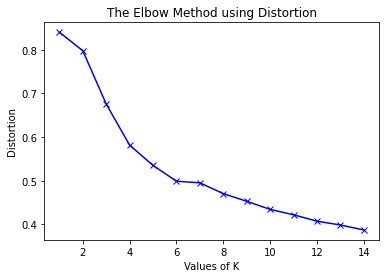

In [21]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

[Text(0.5, 0, 'powlaw_gamma')]

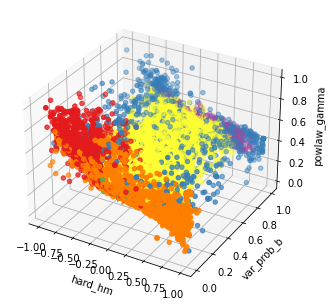

In [23]:
# %matplotlib notebook

colx = X_df.columns.get_loc("hard_hm")
coly = X_df.columns.get_loc("var_prob_b")
colz = X_df.columns.get_loc("powlaw_gamma")

colores=['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33'] # 6
markers=["o", "v", "1", "s", "X", "P"]
asignar=[]
for row in labels:
    asignar.append(colores[row])
    
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, colx], X[:, coly], X[:, colz], c=asignar,s=20)
ax.scatter(C[:, colx], C[:, coly], C[:, colz], marker='*', c=colores, s=1000)
ax.set(xlabel = X_df.columns[colx])
ax.set(ylabel = X_df.columns[coly])
ax.set(zlabel = X_df.columns[colz])

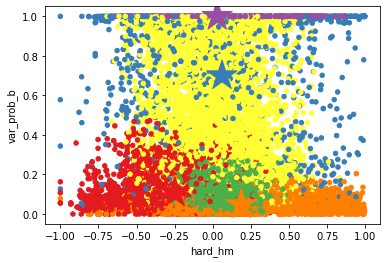

In [25]:
colx = X_df.columns.get_loc("hard_hm")
coly = X_df.columns.get_loc("var_prob_b")
fig = plt.figure()
plt.scatter(X[:, colx], X[:, coly], c=asignar,s=20)
plt.scatter(C[:, colx], C[:, coly], marker='*', c=colores, s=1000)
plt.xlabel(X_df.columns[colx]);
plt.ylabel(X_df.columns[coly]);

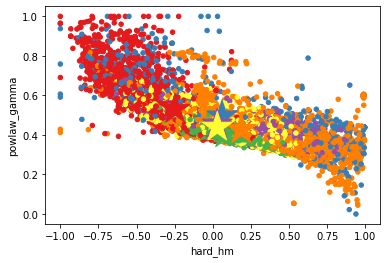

In [27]:
colx = X_df.columns.get_loc("hard_hm")
coly = X_df.columns.get_loc("powlaw_gamma")
fig = plt.figure()
plt.scatter(X[:, colx], X[:, coly], c=asignar,s=20)
plt.scatter(C[:, colx], C[:, coly], marker='*', c=colores, s=1000)
plt.xlabel(X_df.columns[colx]);
plt.ylabel(X_df.columns[coly]);

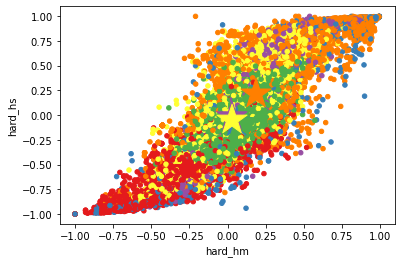

In [28]:
colx = X_df.columns.get_loc("hard_hm")
coly = X_df.columns.get_loc("hard_hs")
fig = plt.figure()
plt.scatter(X[:, colx], X[:, coly], c=asignar,s=20)
plt.scatter(C[:, colx], C[:, coly], marker='*', c=colores, s=1000)
plt.xlabel(X_df.columns[colx]);
plt.ylabel(X_df.columns[coly]);

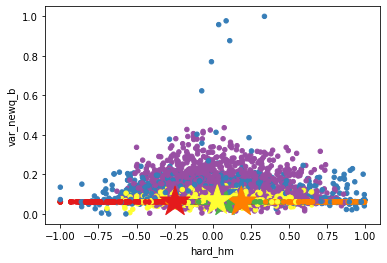

In [30]:
colx = X_df.columns.get_loc("hard_hm")
coly = X_df.columns.get_loc("var_newq_b")
fig = plt.figure()
plt.scatter(X[:, colx], X[:, coly], c=asignar,s=20)
plt.scatter(C[:, colx], C[:, coly], marker='*', c=colores, s=1000)
plt.xlabel(X_df.columns[colx]);
plt.ylabel(X_df.columns[coly]);

In [31]:
X_df_out_final = X_df_out.copy(deep=True)
X_df_out_final['cluster'] = labels

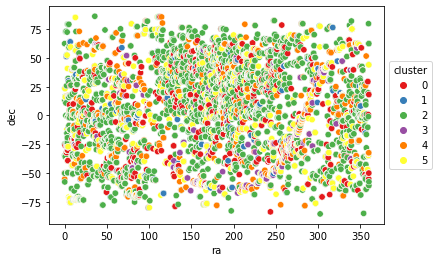

In [32]:
X_np_out=X_df_out_final.to_numpy()
colors = sns.color_palette()[0:6]

colx = X_df_out_final.columns.get_loc("ra")
coly = X_df_out_final.columns.get_loc("dec")
fig = plt.figure()
s = sns.scatterplot(data=X_df_out_final, x='ra', y='dec', hue=X_df_out_final["cluster"], palette=colores, s=40);
s.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, title='cluster')
plt.xlabel(X_df_out_final.columns[colx]);
plt.ylabel(X_df_out_final.columns[coly]);
plt.show()

In [33]:
X_df_out_final.to_csv('cluster_data/clusterized_new_xray.csv')